# Machine learning model to build b2b invoice management

In [1]:
import gc
import math
import PIL 
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import random
import warnings
import xgboost as xgb
from scipy import stats
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split , GridSearchCV,cross_val_score,cross_val_predict,cross_validate,RandomizedSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score,max_error,r2_score,median_absolute_error,mean_squared_log_error
from sklearn.feature_selection import VarianceThreshold,SelectKBest,f_regression
from sklearn.preprocessing import MinMaxScaler,normalize,StandardScaler,RobustScaler
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.decomposition import PCA
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


pd. set_option('display.max_columns', 1000) # or 1000.
pd. set_option('display.max_rows', 1000) # or 1000.

In [2]:
df= pd.read_csv("H2HBABBA2466.csv")

In [3]:
df

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,CA02,0140104392,FLANAG foundation,2019-07-22 00:00:00,2019.0,2.960561e+09,2019-07-05,20190705,20190705,20190719.0,CAD,RV,1.0,NaN,4191.27,20190709.0,CA10,2.960561e+09,0
1,U001,200148860,DOLLA in,NaN,2020.0,1.930736e+09,2020-03-29,20200402,20200329,20200413.0,USD,RV,1.0,NaN,29966.41,20200329.0,NAA8,1.930736e+09,1
2,U001,0100031704,DELHAIZE llc,2019-12-19 00:00:00,2019.0,1.930207e+09,2019-12-02,20191130,20191202,20191217.0,USD,RV,1.0,NaN,65299.00,20191202.0,NAA8,1.930207e+09,0
3,U001,0200769623,WAL-MAR llc,2019-12-02 00:00:00,2019.0,1.930174e+09,2019-11-21,20191120,20191121,20191206.0,USD,RV,1.0,NaN,3106.32,20191121.0,NAH4,1.930174e+09,0
4,U001,0200718130,SYSCO F foundation,2019-10-01 00:00:00,2019.0,1.929804e+09,2019-08-28,20190828,20190828,20190929.0,USD,RV,1.0,NaN,31873.44,20190828.0,NA32,1.929804e+09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,U001,0200762301,C&S WH foundation,2019-02-07 00:00:00,2019.0,1.928661e+09,2019-01-23,20190122,20190123,20190207.0,USD,RV,1.0,NaN,76115.38,20190123.0,NAC6,1.928661e+09,0
49996,U001,0200769623,WAL-MAR us,2019-05-10 00:00:00,2019.0,1.929187e+09,2019-04-23,20190422,20190423,20190508.0,USD,RV,1.0,NaN,14610.36,20190423.0,NAH4,1.929187e+09,0
49997,U001,0200794332,COST associates,NaN,2020.0,1.930805e+09,2020-04-21,20200421,20200421,20200506.0,USD,RV,1.0,NaN,19098.48,20200421.0,NAAX,1.930805e+09,1
49998,CA02,140105785,SHOPPE foundation,2019-02-15 00:00:00,2019.0,2.960523e+09,2019-01-21,20190121,20190121,20190208.0,CAD,RV,1.0,NaN,1084.12,20190129.0,CA10,2.960523e+09,0


In [4]:
#Coverting to date format for creating target column
df['clear_date'] = pd.to_datetime(df['clear_date'])
df["due_in_date"]= pd.to_datetime(df.due_in_date,format='%Y%m%d')


In [5]:
#A new column is formed by subtracting the clear_date column with due_in_date column
df["delay"]=df["clear_date"] - df["due_in_date"]
df["delay"]=df["delay"]/np.timedelta64(1,"D")
df

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,delay
0,CA02,0140104392,FLANAG foundation,2019-07-22,2019.0,2.960561e+09,2019-07-05,20190705,20190705,2019-07-19,CAD,RV,1.0,NaN,4191.27,20190709.0,CA10,2.960561e+09,0,3.0
1,U001,200148860,DOLLA in,NaT,2020.0,1.930736e+09,2020-03-29,20200402,20200329,2020-04-13,USD,RV,1.0,NaN,29966.41,20200329.0,NAA8,1.930736e+09,1,NaN
2,U001,0100031704,DELHAIZE llc,2019-12-19,2019.0,1.930207e+09,2019-12-02,20191130,20191202,2019-12-17,USD,RV,1.0,NaN,65299.00,20191202.0,NAA8,1.930207e+09,0,2.0
3,U001,0200769623,WAL-MAR llc,2019-12-02,2019.0,1.930174e+09,2019-11-21,20191120,20191121,2019-12-06,USD,RV,1.0,NaN,3106.32,20191121.0,NAH4,1.930174e+09,0,-4.0
4,U001,0200718130,SYSCO F foundation,2019-10-01,2019.0,1.929804e+09,2019-08-28,20190828,20190828,2019-09-29,USD,RV,1.0,NaN,31873.44,20190828.0,NA32,1.929804e+09,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,U001,0200762301,C&S WH foundation,2019-02-07,2019.0,1.928661e+09,2019-01-23,20190122,20190123,2019-02-07,USD,RV,1.0,NaN,76115.38,20190123.0,NAC6,1.928661e+09,0,0.0
49996,U001,0200769623,WAL-MAR us,2019-05-10,2019.0,1.929187e+09,2019-04-23,20190422,20190423,2019-05-08,USD,RV,1.0,NaN,14610.36,20190423.0,NAH4,1.929187e+09,0,2.0
49997,U001,0200794332,COST associates,NaT,2020.0,1.930805e+09,2020-04-21,20200421,20200421,2020-05-06,USD,RV,1.0,NaN,19098.48,20200421.0,NAAX,1.930805e+09,1,NaN
49998,CA02,140105785,SHOPPE foundation,2019-02-15,2019.0,2.960523e+09,2019-01-21,20190121,20190121,2019-02-08,CAD,RV,1.0,NaN,1084.12,20190129.0,CA10,2.960523e+09,0,7.0


# checking for null values

In [6]:
df.isna().sum()

business_code                 0
cust_number                   0
name_customer                 0
clear_date                10000
buisness_year                 0
doc_id                        0
posting_date                  0
document_create_date          0
document_create_date.1        0
due_in_date                   0
invoice_currency              0
document type                 0
posting_id                    0
area_business             50000
total_open_amount             0
baseline_create_date          0
cust_payment_terms            0
invoice_id                    3
isOpen                        0
delay                     10000
dtype: int64

## Removing the data points where the target value is null

# target column is delay

In [7]:
main_train = df[df.delay.isnull()==False]
main_test =  df[df.delay.isnull()==True]

In [8]:
main_train.isna().sum()

business_code                 0
cust_number                   0
name_customer                 0
clear_date                    0
buisness_year                 0
doc_id                        0
posting_date                  0
document_create_date          0
document_create_date.1        0
due_in_date                   0
invoice_currency              0
document type                 0
posting_id                    0
area_business             40000
total_open_amount             0
baseline_create_date          0
cust_payment_terms            0
invoice_id                    3
isOpen                        0
delay                         0
dtype: int64

In [9]:
main_train

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,delay
0,CA02,0140104392,FLANAG foundation,2019-07-22,2019.0,2.960561e+09,2019-07-05,20190705,20190705,2019-07-19,CAD,RV,1.0,NaN,4191.27,20190709.0,CA10,2.960561e+09,0,3.0
2,U001,0100031704,DELHAIZE llc,2019-12-19,2019.0,1.930207e+09,2019-12-02,20191130,20191202,2019-12-17,USD,RV,1.0,NaN,65299.00,20191202.0,NAA8,1.930207e+09,0,2.0
3,U001,0200769623,WAL-MAR llc,2019-12-02,2019.0,1.930174e+09,2019-11-21,20191120,20191121,2019-12-06,USD,RV,1.0,NaN,3106.32,20191121.0,NAH4,1.930174e+09,0,-4.0
4,U001,0200718130,SYSCO F foundation,2019-10-01,2019.0,1.929804e+09,2019-08-28,20190828,20190828,2019-09-29,USD,RV,1.0,NaN,31873.44,20190828.0,NA32,1.929804e+09,0,2.0
5,U001,200769623,WAL-MAR,2019-07-15,2019.0,1.929554e+09,2019-07-03,20190629,20190703,2019-07-18,USD,RV,1.0,NaN,20412.80,20190703.0,NAH4,1.929554e+09,0,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49994,U001,0200772670,ASSOCIAT associates,2019-03-29,2019.0,1.928976e+09,2019-03-16,20190316,20190316,2019-03-31,USD,RV,1.0,NaN,721.02,20190316.0,NAU5,1.928976e+09,0,-2.0
49995,U001,0200762301,C&S WH foundation,2019-02-07,2019.0,1.928661e+09,2019-01-23,20190122,20190123,2019-02-07,USD,RV,1.0,NaN,76115.38,20190123.0,NAC6,1.928661e+09,0,0.0
49996,U001,0200769623,WAL-MAR us,2019-05-10,2019.0,1.929187e+09,2019-04-23,20190422,20190423,2019-05-08,USD,RV,1.0,NaN,14610.36,20190423.0,NAH4,1.929187e+09,0,2.0
49998,CA02,140105785,SHOPPE foundation,2019-02-15,2019.0,2.960523e+09,2019-01-21,20190121,20190121,2019-02-08,CAD,RV,1.0,NaN,1084.12,20190129.0,CA10,2.960523e+09,0,7.0


## Preprocessing

#### Null Imputation

In [10]:
#Dropping the record containing null value as the invoice_id is MCAR 
main_train[main_train.invoice_id.isnull()]

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,delay
13613,CA02,0100030194,AMAZO foundation,2019-12-27,2019.0,9.500000e+09,2019-03-29,20190329,20190320,2019-03-30,CAD,X2,1.0,NaN,1326.00,20190320.0,CA10,NaN,0,272.0
22322,CA02,0140106054,TREE in,2019-05-31,2019.0,9.500000e+09,2019-03-29,20190329,20190305,2019-03-15,CAD,X2,1.0,NaN,349.52,20190305.0,CA10,NaN,0,77.0
39422,CA02,0140106054,TREE associates,2019-05-09,2019.0,9.500000e+09,2019-03-29,20190329,20190213,2019-02-23,CAD,X2,1.0,NaN,216.80,20190213.0,CA10,NaN,0,75.0


In [11]:
main_train["doc_id"]=main_train.doc_id.astype(int)
main_train["buisness_year"]=main_train.buisness_year.astype(int)

In [12]:
comparison_column = np.where(main_train["doc_id"] == main_train["invoice_id"], True, False)
comparison_column

array([False,  True,  True, ...,  True, False,  True])

In [13]:
#drppping invoice_id as the doc_id and invoice_id are same in main_train
main_train.drop("invoice_id",axis=1,inplace=True)

In [14]:
#dropping area_business as it contains all null values
main_train.drop("area_business",axis=1,inplace=True)

## Date and Time Conversion

In [15]:
main_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   business_code           40000 non-null  object        
 1   cust_number             40000 non-null  object        
 2   name_customer           40000 non-null  object        
 3   clear_date              40000 non-null  datetime64[ns]
 4   buisness_year           40000 non-null  int32         
 5   doc_id                  40000 non-null  int32         
 6   posting_date            40000 non-null  object        
 7   document_create_date    40000 non-null  int64         
 8   document_create_date.1  40000 non-null  int64         
 9   due_in_date             40000 non-null  datetime64[ns]
 10  invoice_currency        40000 non-null  object        
 11  document type           40000 non-null  object        
 12  posting_id              40000 non-null  float6

In [16]:
main_train["posting_date"]= pd.to_datetime(main_train["posting_date"])
main_train["document_create_date"]= pd.to_datetime(main_train.document_create_date,format='%Y%m%d')
main_train["baseline_create_date"]= pd.to_datetime(main_train.baseline_create_date,format='%Y%m%d')



In [17]:
#renaming the column document_create_date.1 to document_create_date1 for changing it to the datetime format
main_train.rename(columns={"document_create_date.1":"document_create_date1"}, inplace=True)

In [18]:
main_train["document_create_date1"]= pd.to_datetime(main_train.document_create_date1,format='%Y%m%d')

In [19]:
main_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   business_code          40000 non-null  object        
 1   cust_number            40000 non-null  object        
 2   name_customer          40000 non-null  object        
 3   clear_date             40000 non-null  datetime64[ns]
 4   buisness_year          40000 non-null  int32         
 5   doc_id                 40000 non-null  int32         
 6   posting_date           40000 non-null  datetime64[ns]
 7   document_create_date   40000 non-null  datetime64[ns]
 8   document_create_date1  40000 non-null  datetime64[ns]
 9   due_in_date            40000 non-null  datetime64[ns]
 10  invoice_currency       40000 non-null  object        
 11  document type          40000 non-null  object        
 12  posting_id             40000 non-null  float64       
 13  t

## Duplicate/Constant column removal

In [20]:
#dropping document_create_date1 because it has the same values as posting_date
main_train.drop("document_create_date1",axis=1,inplace=True)

In [21]:
main_train.nunique()

business_code               6
cust_number              1301
name_customer            3843
clear_date                397
buisness_year               2
doc_id                  36184
posting_date              423
document_create_date      424
due_in_date               489
invoice_currency            2
document type               2
posting_id                  1
total_open_amount       35655
baseline_create_date      435
cust_payment_terms         73
isOpen                      1
delay                     183
dtype: int64

In [22]:
main_train.business_code.value_counts()

U001    36352
CA02     3009
U013      507
U002      116
U005       10
U007        6
Name: business_code, dtype: int64

# clubbing low occuring data set together

In [23]:
main_train["business_code"]= np.where(main_train["business_code"].isin(["U005","U007"]),"Others",main_train["business_code"])

In [24]:
#check variance
main_train.nunique()

business_code               5
cust_number              1301
name_customer            3843
clear_date                397
buisness_year               2
doc_id                  36184
posting_date              423
document_create_date      424
due_in_date               489
invoice_currency            2
document type               2
posting_id                  1
total_open_amount       35655
baseline_create_date      435
cust_payment_terms         73
isOpen                      1
delay                     183
dtype: int64

In [25]:
#renaming document type to document_type 
main_train.rename(columns={"document type":"document_type"}, inplace=True)


In [26]:
main_train.posting_id.value_counts()

1.0    40000
Name: posting_id, dtype: int64

In [27]:
#renaming isOpen to is_open
main_train.rename(columns={"isOpen":"is_open"}, inplace=True)

In [28]:
main_train.is_open.value_counts()

0    40000
Name: is_open, dtype: int64

In [29]:
main_train.drop("posting_id",axis=1,inplace=True)
main_train.drop("is_open",axis=1,inplace=True)

In [30]:
main_train

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,invoice_currency,document_type,total_open_amount,baseline_create_date,cust_payment_terms,delay
0,CA02,0140104392,FLANAG foundation,2019-07-22,2019,-2147483648,2019-07-05,2019-07-05,2019-07-19,CAD,RV,4191.27,2019-07-09,CA10,3.0
2,U001,0100031704,DELHAIZE llc,2019-12-19,2019,1930206848,2019-12-02,2019-11-30,2019-12-17,USD,RV,65299.00,2019-12-02,NAA8,2.0
3,U001,0200769623,WAL-MAR llc,2019-12-02,2019,1930174426,2019-11-21,2019-11-20,2019-12-06,USD,RV,3106.32,2019-11-21,NAH4,-4.0
4,U001,0200718130,SYSCO F foundation,2019-10-01,2019,1929803572,2019-08-28,2019-08-28,2019-09-29,USD,RV,31873.44,2019-08-28,NA32,2.0
5,U001,200769623,WAL-MAR,2019-07-15,2019,1929554421,2019-07-03,2019-06-29,2019-07-18,USD,RV,20412.80,2019-07-03,NAH4,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49994,U001,0200772670,ASSOCIAT associates,2019-03-29,2019,1928975777,2019-03-16,2019-03-16,2019-03-31,USD,RV,721.02,2019-03-16,NAU5,-2.0
49995,U001,0200762301,C&S WH foundation,2019-02-07,2019,1928661442,2019-01-23,2019-01-22,2019-02-07,USD,RV,76115.38,2019-01-23,NAC6,0.0
49996,U001,0200769623,WAL-MAR us,2019-05-10,2019,1929186968,2019-04-23,2019-04-22,2019-05-08,USD,RV,14610.36,2019-04-23,NAH4,2.0
49998,CA02,140105785,SHOPPE foundation,2019-02-15,2019,-2147483648,2019-01-21,2019-01-21,2019-02-08,CAD,RV,1084.12,2019-01-29,CA10,7.0


In [31]:
main_train=main_train.drop_duplicates(keep='first')
main_train.shape

(39121, 15)

In [32]:
#dropping invoice_currency column as business_code has the details of whether the amount is USD or CAD
main_train.drop("invoice_currency",axis=1,inplace=True)


In [33]:
main_train.sort_values(by=["posting_date"],inplace=True)

In [34]:
main_train

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,document_type,total_open_amount,baseline_create_date,cust_payment_terms,delay
26482,CA02,0140104423,METRO us,2019-01-15,2019,-2147483648,2018-12-30,2018-12-30,2019-01-13,RV,23464.08,2019-01-03,CA10,2.0
49243,U001,0200759878,SA,2019-01-15,2019,1928537897,2018-12-30,2018-12-29,2019-01-14,RV,24575.57,2018-12-30,NAH4,1.0
33130,U001,CCU013,KRAFT F foundation,2019-03-01,2019,1928516980,2018-12-30,2018-12-31,2018-12-30,RV,17592.60,2018-12-30,NAX2,61.0
45352,CA02,0140106408,WAL-M foundation,2019-01-25,2019,-2147483648,2018-12-30,2018-12-30,2019-01-09,RV,60289.21,2018-12-30,CA10,16.0
39016,U001,0200726979,BJ'S us,2019-01-15,2019,1928538240,2018-12-30,2018-12-29,2019-01-14,RV,214.47,2018-12-30,NAA8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23861,U001,0200739044,PERFOR corporation,2020-03-16,2020,1930573889,2020-02-27,2020-02-26,2020-03-13,RV,25143.02,2020-02-27,NAA8,3.0
37514,CA02,0140105686,SYSC foundation,2020-03-12,2020,-2147483648,2020-02-27,2020-02-27,2020-03-10,RV,24800.80,2020-02-29,CA10,2.0
32496,U001,0200759878,SA corp,2020-03-13,2020,1930573843,2020-02-27,2020-02-26,2020-03-13,RV,49290.19,2020-02-27,NAH4,0.0
42908,U001,0200739941,FOX us,2020-03-16,2020,1930573835,2020-02-27,2020-02-26,2020-03-13,RV,25360.00,2020-02-27,NAA8,3.0


In [35]:
#removing baseline_create_date as it has the same values of posting_date
main_train.drop("baseline_create_date",axis=1,inplace=True)
main_train
#removing document_type as it has an array of same values "RV".
main_train.drop("document_type",axis=1,inplace=True)

### Split Data

##### splitting the main_train data into Train,Validation and test

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X= main_train.drop(["delay"],axis=1)

In [38]:
y=main_train["delay"]

In [39]:
X_train,X_inter_test,y_train,y_inter_test=train_test_split(X,y,test_size=0.3,random_state=0,shuffle=False)

In [40]:
X_train.shape,X_inter_test.shape

((27384, 11), (11737, 11))

In [41]:
X_val,X_test,y_val,y_test = train_test_split(X_inter_test,y_inter_test,test_size=0.5,random_state=0,shuffle=False)

In [42]:
X_train.shape ,X_val.shape ,X_test.shape

((27384, 11), (5868, 11), (5869, 11))

# EDA

<AxesSubplot:xlabel='delay', ylabel='Density'>

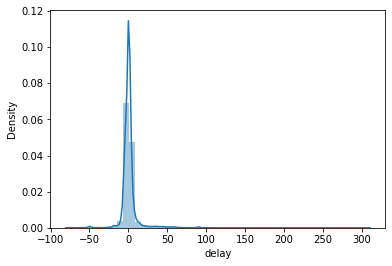

In [43]:
sns.distplot(y_train)

<AxesSubplot:xlabel='delay', ylabel='Count'>

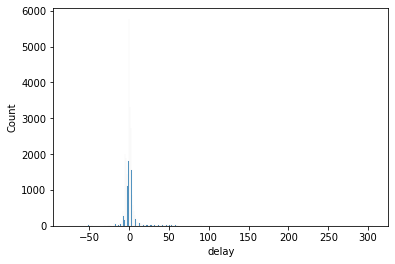

In [44]:
sns.histplot(y_train)

In [45]:
X_train.merge(y_train,on = X_train.index)

,key_0,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,total_open_amount,cust_payment_terms,delay
0,26482,CA02,0140104423,METRO us,2019-01-15,2019,-2147483648,2018-12-30,2018-12-30,2019-01-13,23464.08,CA10,2.0
1,49243,U001,0200759878,SA,2019-01-15,2019,1928537897,2018-12-30,2018-12-29,2019-01-14,24575.57,NAH4,1.0
2,33130,U001,CCU013,KRAFT F foundation,2019-03-01,2019,1928516980,2018-12-30,2018-12-31,2018-12-30,17592.60,NAX2,61.0
3,45352,CA02,0140106408,WAL-M foundation,2019-01-25,2019,-2147483648,2018-12-30,2018-12-30,2019-01-09,60289.21,CA10,16.0
4,39016,U001,0200726979,BJ'S us,2019-01-15,2019,1928538240,2018-12-30,2018-12-29,2019-01-14,214.47,NAA8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27379,14374,U001,0200774000,RALEY co,2019-10-23,2019,1929989789,2019-10-09,2019-10-09,2019-10-24,68585.02,NAA8,-1.0
27380,21043,U001,0200770677,KRAS corp,2019-10-25,2019,1929987314,2019-10-09,2019-10-08,2019-10-24,22416.53,NAA8,1.0
27381,36496,U001,0200769623,WAL-MAR corporation,2019-10-21,2019,1929987903,2019-10-09,2019-10-08,2019-10-24,12170.67,NAH4,-3.0
27382,4733,U001,0200785971,SYSCO co,2019-11-12,2019,1929995489,2019-10-09,2019-10-10,2019-11-10,24460.56,NA32,2.0


<AxesSubplot:xlabel='delay', ylabel='clear_date'>

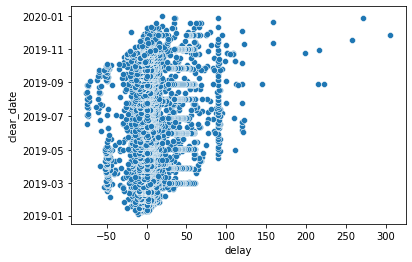

In [46]:
sns.scatterplot(data = X_train.merge(y_train,on=X_train.index), x = "delay" , y = "clear_date")

In [47]:
coun_t  = X_train.nunique().to_frame(name = 'count')
coun_t

,count
business_code,5
cust_number,1194
name_customer,3290
clear_date,284
buisness_year,1
doc_id,25237
posting_date,284
document_create_date,289
due_in_date,338
total_open_amount,25141


<AxesSubplot:xlabel='delay', ylabel='total_open_amount'>

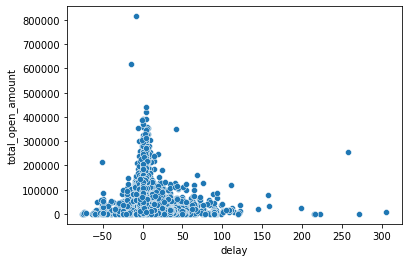

In [48]:
sns.scatterplot(data = X_train.merge(y_train,on=X_train.index), x = "delay" , y = "total_open_amount")

# Mode - Most Frequently occuring Element

In [49]:
X_train[['buisness_year']].agg(pd.Series.mode) 

,buisness_year
0,2019


# Median

In [50]:
X_train[['buisness_year']].agg(np.median).to_frame()  

,0
buisness_year,2019.0


# mean and std

In [51]:
X_train['total_open_amount'].agg(['mean','std']).to_frame()

,total_open_amount
mean,31631.695354
std,39356.190172


## Feature Engineering

##### Changing values to int or float format

In [52]:
from sklearn.preprocessing import LabelEncoder

In [53]:
#Encoding the values of name_customer to name_customer_enc using LabelEncoder
name_customer_enc = LabelEncoder()
name_customer_enc.fit(X_train["name_customer"])
X_train["name_customer_enc"]=name_customer_enc.transform(X_train["name_customer"])

In [54]:
name_customer_enc.fit(X_test["name_customer"])
X_test["name_customer_enc"]=name_customer_enc.transform(X_test["name_customer"])

In [55]:
name_customer_enc.fit(X_val["name_customer"])
X_val["name_customer_enc"]=name_customer_enc.transform(X_val["name_customer"])

In [56]:
#dropping the values of name customer in train,val and test
X_train.drop(["name_customer"],inplace=True,axis=1)
X_val.drop(["name_customer"],inplace=True,axis=1)
X_test.drop(["name_customer"],inplace=True,axis=1)

In [57]:
#creating a function shrey for dropping the future values of X_train,X_val,X_test
def shrey(col , traindf = X_train,valdf =X_val,testdf =X_test):
    traindf.drop(col,inplace=True,axis=1)
    valdf.drop(col,inplace=True,axis=1)
    testdf.drop(col,inplace=True,axis=1)
    return traindf,valdf,testdf

### Changing the date values into seperate columns as Year, Day and month

In [58]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27384 entries, 26482 to 44497
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   business_code         27384 non-null  object        
 1   cust_number           27384 non-null  object        
 2   clear_date            27384 non-null  datetime64[ns]
 3   buisness_year         27384 non-null  int32         
 4   doc_id                27384 non-null  int32         
 5   posting_date          27384 non-null  datetime64[ns]
 6   document_create_date  27384 non-null  datetime64[ns]
 7   due_in_date           27384 non-null  datetime64[ns]
 8   total_open_amount     27384 non-null  float64       
 9   cust_payment_terms    27384 non-null  object        
 10  name_customer_enc     27384 non-null  int32         
dtypes: datetime64[ns](4), float64(1), int32(3), object(3)
memory usage: 2.2+ MB


In [59]:

X_train["year_posting_date"]= X_train["posting_date"].dt.year
X_val["year_posting_date"]= X_val["posting_date"].dt.year
X_test["week_posting_date"]= X_test["posting_date"].dt.year

X_train["day_posting_date"]= X_train["posting_date"].dt.day
X_val["day_posting_day"]= X_val["posting_date"].dt.day
X_test["day_posting_day"]= X_test["posting_date"].dt.day

X_train["month_posting_date"]= X_train["posting_date"].dt.month
X_val["month_posting_date"]= X_val["posting_date"].dt.month
X_test["month_posting_date"]= X_test["posting_date"].dt.month

In [60]:
X_train,X_val,X_test = shrey(["posting_date"])

In [61]:
X_train["year_due_in_date"]= X_train["due_in_date"].dt.year
X_val["year_due_in_date"]= X_val["due_in_date"].dt.year
X_test["year_due_in_date"]= X_test["due_in_date"].dt.year

X_train["day_due_in_date"]= X_train["due_in_date"].dt.day
X_val["day_due_in_date"]= X_val["due_in_date"].dt.day
X_test["day_due_in_date"]= X_test["due_in_date"].dt.day

X_train["month_due_in_date"]= X_train["due_in_date"].dt.month
X_val["month_due_in_date"]= X_val["due_in_date"].dt.month
X_test["month_due_in_date"]= X_test["due_in_date"].dt.month

In [62]:
X_train,X_val,X_test = shrey(["due_in_date"])

In [63]:
X_train["year_document_create_date"]= X_train["document_create_date"].dt.year
X_val["year_document_create_date"]= X_val["document_create_date"].dt.year
X_test["year_document_create_date"]= X_test["document_create_date"].dt.year

X_train["day_document_create_date"]= X_train["document_create_date"].dt.day
X_val["day_document_create_date"]= X_val["document_create_date"].dt.day
X_test["day_document_create_date"]= X_test["document_create_date"].dt.day

X_train["month_document_create_date"]= X_train["document_create_date"].dt.month
X_val["month_document_create_date"]= X_val["document_create_date"].dt.month
X_test["month_document_create_date"]= X_test["document_create_date"].dt.month

In [64]:
X_train,X_val,X_test = shrey(["document_create_date"])

In [65]:
#Encoding the values of cust_payment_terms to cust_payment_terms_enc using LabelEncoder
cust_payment_terms_enc = LabelEncoder()
cust_payment_terms_enc.fit(X_train["cust_payment_terms"])
X_train["cust_payment_terms_enc"]=cust_payment_terms_enc.transform(X_train["cust_payment_terms"])

In [66]:
cust_payment_terms_enc.fit(X_val["cust_payment_terms"])
X_val["cust_payment_terms_enc"]=cust_payment_terms_enc.transform(X_val["cust_payment_terms"])
cust_payment_terms_enc.fit(X_test["cust_payment_terms"])
X_test["cust_payment_terms_enc"]=cust_payment_terms_enc.transform(X_test["cust_payment_terms"])

In [67]:
X_train,X_val,X_test = shrey(["cust_payment_terms"])

#### Splitting the mixed column to Labels's and numericals seperately

In [68]:
mixed_cust_num="cust_number"
mixed_num_in_cust_num= mixed_cust_num + "_numerical"
mixed_label_in_cust_num= mixed_cust_num + "_label"

In [69]:
X_train[mixed_num_in_cust_num]=X_train[mixed_cust_num].str.extract('(\d+)')

In [70]:
X_train[mixed_label_in_cust_num]=X_train[mixed_cust_num].str[:3]

In [71]:
X_train["cust_number_numerical"]=X_train.cust_number_numerical.astype(int)

In [72]:
X_val[mixed_num_in_cust_num]=X_val[mixed_cust_num].str.extract('(\d+)')
X_val[mixed_label_in_cust_num]=X_val[mixed_cust_num].str[:3]
X_val["cust_number_numerical"]=X_val.cust_number_numerical.astype(int)

X_test[mixed_num_in_cust_num]=X_test[mixed_cust_num].str.extract('(\d+)')
X_test[mixed_label_in_cust_num]=X_test[mixed_cust_num].str[:3]
X_test["cust_number_numerical"]=X_test.cust_number_numerical.astype(int)

In [73]:
cust_number_label_enc = LabelEncoder()
cust_number_label_enc.fit(X_train["cust_number_label"])
X_train["cust_number_label_enc"]=cust_number_label_enc.transform(X_train["cust_number_label"])

In [74]:
cust_number_label_enc.fit(X_val["cust_number_label"])
X_val["cust_number_label_enc"]=cust_number_label_enc.transform(X_val["cust_number_label"])
cust_number_label_enc.fit(X_test["cust_number_label"])
X_test["cust_number_label_enc"]=cust_number_label_enc.transform(X_test["cust_number_label"])

In [75]:
X_train,X_val,X_test = shrey(["cust_number"])
X_train,X_val,X_test = shrey(["cust_number_label"])

In [76]:
#Encoding the values of business_code to business_code_enc using LabelEncoder
business_code_enc = LabelEncoder()
business_code_enc.fit(X_train["business_code"])
X_train["business_code_enc"]=business_code_enc.transform(X_train["business_code"])

business_code_enc.fit(X_val["business_code"])
X_val["business_code_enc"]=business_code_enc.transform(X_val["business_code"])

business_code_enc.fit(X_test["business_code"])
X_test["business_code_enc"]=business_code_enc.transform(X_test["business_code"])

In [77]:
X_train,X_val,X_test = shrey(["business_code"])

In [78]:
X_train,X_val,X_test = shrey(["clear_date"])

In [79]:
X_train

,buisness_year,doc_id,total_open_amount,name_customer_enc,year_posting_date,day_posting_date,month_posting_date,year_due_in_date,day_due_in_date,month_due_in_date,year_document_create_date,day_document_create_date,month_document_create_date,cust_payment_terms_enc,cust_number_numerical,cust_number_label_enc,business_code_enc
26482,2019,-2147483648,23464.08,2015,2018,30,12,2019,13,1,2018,30,12,7,140104423,1,0
49243,2019,1928537897,24575.57,2521,2018,30,12,2019,14,1,2018,29,12,35,200759878,2,2
33130,2019,1928516980,17592.60,1643,2018,30,12,2018,30,12,2018,31,12,68,13,11,2
45352,2019,-2147483648,60289.21,3176,2018,30,12,2019,9,1,2018,30,12,7,140106408,1,0
39016,2019,1928538240,214.47,344,2018,30,12,2019,14,1,2018,29,12,22,200726979,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14374,2019,1929989789,68585.02,2409,2019,9,10,2019,24,10,2019,9,10,22,200774000,2,2
21043,2019,1929987314,22416.53,1651,2019,9,10,2019,24,10,2019,8,10,22,200770677,2,2
36496,2019,1929987903,12170.67,3186,2019,9,10,2019,24,10,2019,8,10,35,200769623,2,2
4733,2019,1929995489,24460.56,2882,2019,9,10,2019,10,11,2019,10,10,15,200785971,2,2


## Feature Selection

In [80]:
X_train.merge(y_train,on=X_train.index).corr()

,key_0,buisness_year,doc_id,total_open_amount,name_customer_enc,year_posting_date,day_posting_date,month_posting_date,year_due_in_date,day_due_in_date,month_due_in_date,year_document_create_date,day_document_create_date,month_document_create_date,cust_payment_terms_enc,cust_number_numerical,cust_number_label_enc,business_code_enc,delay
key_0,1.000000,NaN,-0.003019,-0.002859,-0.004934,-0.009102,0.013721,0.000658,-0.003432,-0.002263,-0.000120,-0.008907,0.012569,0.001367,0.009857,-0.003595,0.010814,-0.002986,0.014465
buisness_year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
doc_id,-0.003019,NaN,1.000000,-0.183580,0.008802,-0.006440,-0.001306,-0.010585,-0.001753,0.006126,0.000771,-0.015736,-0.005409,-0.009442,0.520062,0.326411,0.178787,0.920632,-0.141377
total_open_amount,-0.002859,NaN,-0.183580,1.000000,-0.000628,-0.000909,0.016914,0.007162,0.002156,-0.015249,0.000517,0.003657,0.021311,0.006925,-0.206196,-0.012266,-0.076816,-0.176044,0.006260
name_customer_enc,-0.004934,NaN,0.008802,-0.000628,1.000000,-0.024849,0.011296,-0.009395,0.001926,-0.007473,-0.020861,-0.025436,0.017361,-0.008716,0.100932,0.113661,-0.021075,-0.007973,-0.021255
year_posting_date,-0.009102,NaN,-0.006440,-0.000909,-0.024849,1.000000,-0.109340,-0.165014,0.092652,0.009528,0.112243,0.763392,-0.097164,-0.155003,-0.006266,-0.005461,0.004552,-0.005513,-0.006051
day_posting_date,0.013721,NaN,-0.001306,0.016914,0.011296,-0.109340,1.000000,-0.061172,-0.009772,-0.371788,0.053976,-0.034511,0.838007,-0.063175,0.003617,0.002820,-0.015748,-0.001178,-0.007648
month_posting_date,0.000658,NaN,-0.010585,0.007162,-0.009395,-0.165014,-0.061172,1.000000,-0.015289,0.035063,0.936769,-0.074769,-0.051153,0.974519,0.012394,-0.011893,-0.023316,-0.007974,-0.017215
year_due_in_date,-0.003432,NaN,-0.001753,0.002156,0.001926,0.092652,-0.009772,-0.015289,1.000000,-0.010073,-0.014047,0.073274,-0.010523,-0.015215,-0.021077,0.026104,-0.029634,-0.001299,-0.030478
day_due_in_date,-0.002263,NaN,0.006126,-0.015249,-0.007473,0.009528,-0.371788,0.035063,-0.010073,1.000000,-0.107971,0.007899,-0.373795,0.035107,0.003802,0.000174,0.016827,0.003228,-0.014543


<AxesSubplot:title={'center':'Pearson Correlation Features'}>

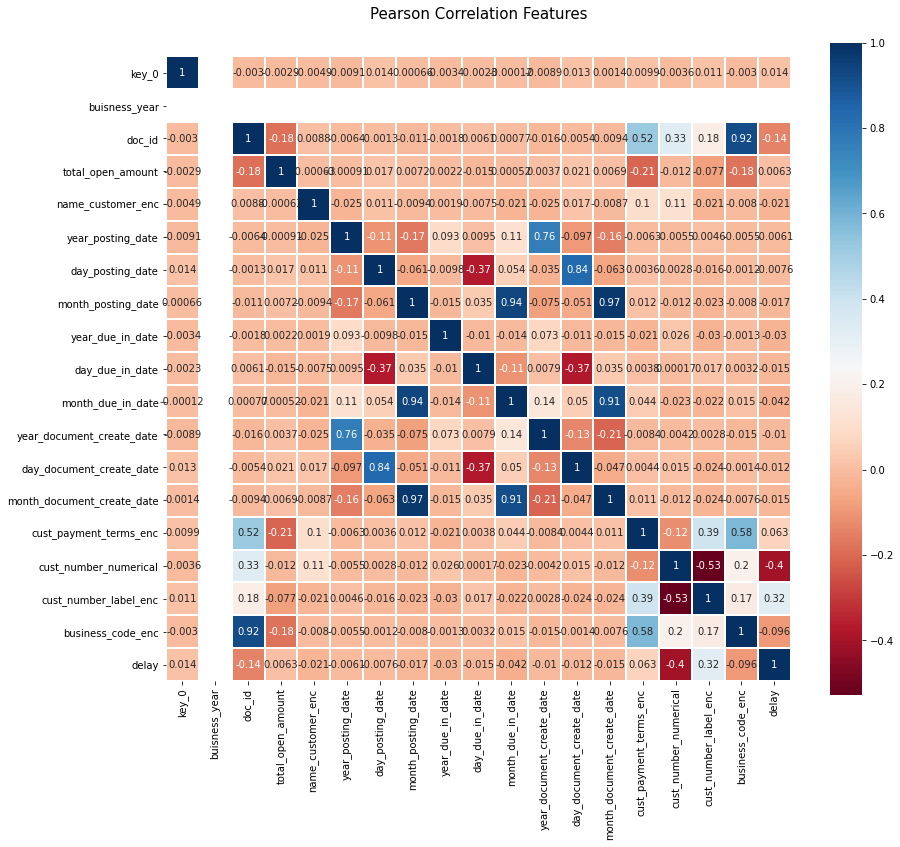

In [81]:
#Plotting colormap
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title("Pearson Correlation Features",y=1.05,size=15)
sns.heatmap(X_train.merge(y_train,on=X_train.index).corr(),linewidths=0.1,vmax=1.0,
           square=True, cmap=colormap, linecolor="white", annot=True)

# Modelling

In [82]:
from sklearn.linear_model import LinearRegression
base_model = LinearRegression()
base_model.fit(X_train,y_train)

LinearRegression()

#### Linear regression algorithm

In [83]:
y_predict=base_model.predict(X_val)

In [84]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_val, y_predict, squared=False)

6.304995752619599

In [85]:
pd.DataFrame(zip(y_val,y_predict),columns=["clear_date_predicted","target_clear_date"])

,clear_date_predicted,target_clear_date
0,4.0,-3.892973
1,-3.0,-3.435366
2,-8.0,-3.220807
3,-3.0,-3.421157
4,-2.0,-3.986745
...,...,...
5863,1.0,-3.669453
5864,0.0,-5.225325
5865,-2.0,-4.210413
5866,-3.0,-3.741085


In [86]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0 , max_depth=5)

#### Decision tree regression algorithm

In [87]:
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=0)

In [88]:
predicted2 =regressor.predict(X_val)

In [89]:
mean_squared_error(y_val,predicted2,squared=False)

7.66549536396542

In [90]:
y_predict_test = regressor.predict(X_test)
mean_squared_error(y_test, y_predict_test, squared=False)

10.011736790867904

# The lost data

In [91]:
main_test

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,delay
1,U001,200148860,DOLLA in,NaT,2020.0,1.930736e+09,2020-03-29,20200402,20200329,2020-04-13,USD,RV,1.0,NaN,29966.41,20200329.0,NAA8,1.930736e+09,1,NaN
17,U001,0200739006,AL systems,NaT,2020.0,1.930740e+09,2020-04-04,20200403,20200404,2020-04-19,USD,RV,1.0,NaN,33248.98,20200404.0,NAA8,1.930740e+09,1,NaN
18,U001,0200769623,WAL-MAR trust,NaT,2020.0,1.930876e+09,2020-05-08,20200507,20200508,2020-05-23,USD,RV,1.0,NaN,35624.49,20200508.0,NAH4,1.930876e+09,1,NaN
24,U001,0200148860,DOLLA corp,NaT,2020.0,1.930624e+09,2020-03-11,20200309,20200311,2020-03-26,USD,RV,1.0,NaN,30057.44,20200311.0,NAA8,1.930624e+09,1,NaN
25,U001,0200769623,WAL-MAR us,NaT,2020.0,1.930850e+09,2020-05-04,20200502,20200504,2020-05-19,USD,RV,1.0,NaN,42124.15,20200504.0,NAH4,1.930850e+09,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49967,U001,0200769623,WAL-MAR co,NaT,2020.0,1.930838e+09,2020-04-30,20200429,20200430,2020-05-15,USD,RV,1.0,NaN,26001.53,20200430.0,NAH4,1.930838e+09,1,NaN
49970,U001,0200806580,BE associates,NaT,2020.0,1.930789e+09,2020-04-16,20200415,20200416,2020-05-01,USD,RV,1.0,NaN,15555.80,20200416.0,NAA8,1.930789e+09,1,NaN
49978,U001,200772670,ASSOCIAT foundation,NaT,2020.0,1.930673e+09,2020-03-19,20200319,20200319,2020-04-03,USD,RV,1.0,NaN,68236.51,20200319.0,NAU5,1.930673e+09,1,NaN
49986,CA02,140105686,SYSC corp,NaT,2020.0,2.960629e+09,2020-04-19,20200419,20200419,2020-05-08,CAD,RV,1.0,NaN,2153.76,20200428.0,CA10,2.960629e+09,1,NaN


In [92]:
main_test.isna().sum()

business_code                 0
cust_number                   0
name_customer                 0
clear_date                10000
buisness_year                 0
doc_id                        0
posting_date                  0
document_create_date          0
document_create_date.1        0
due_in_date                   0
invoice_currency              0
document type                 0
posting_id                    0
area_business             10000
total_open_amount             0
baseline_create_date          0
cust_payment_terms            0
invoice_id                    0
isOpen                        0
delay                     10000
dtype: int64

### Doing the same preprocessing and Feature engineering steps

In [93]:
#Removing the target clear date and clear date from X_main_test
X_main_test= main_test.drop(["delay","clear_date"],axis =1)
X_main_test

,business_code,cust_number,name_customer,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
1,U001,200148860,DOLLA in,2020.0,1.930736e+09,2020-03-29,20200402,20200329,2020-04-13,USD,RV,1.0,NaN,29966.41,20200329.0,NAA8,1.930736e+09,1
17,U001,0200739006,AL systems,2020.0,1.930740e+09,2020-04-04,20200403,20200404,2020-04-19,USD,RV,1.0,NaN,33248.98,20200404.0,NAA8,1.930740e+09,1
18,U001,0200769623,WAL-MAR trust,2020.0,1.930876e+09,2020-05-08,20200507,20200508,2020-05-23,USD,RV,1.0,NaN,35624.49,20200508.0,NAH4,1.930876e+09,1
24,U001,0200148860,DOLLA corp,2020.0,1.930624e+09,2020-03-11,20200309,20200311,2020-03-26,USD,RV,1.0,NaN,30057.44,20200311.0,NAA8,1.930624e+09,1
25,U001,0200769623,WAL-MAR us,2020.0,1.930850e+09,2020-05-04,20200502,20200504,2020-05-19,USD,RV,1.0,NaN,42124.15,20200504.0,NAH4,1.930850e+09,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49967,U001,0200769623,WAL-MAR co,2020.0,1.930838e+09,2020-04-30,20200429,20200430,2020-05-15,USD,RV,1.0,NaN,26001.53,20200430.0,NAH4,1.930838e+09,1
49970,U001,0200806580,BE associates,2020.0,1.930789e+09,2020-04-16,20200415,20200416,2020-05-01,USD,RV,1.0,NaN,15555.80,20200416.0,NAA8,1.930789e+09,1
49978,U001,200772670,ASSOCIAT foundation,2020.0,1.930673e+09,2020-03-19,20200319,20200319,2020-04-03,USD,RV,1.0,NaN,68236.51,20200319.0,NAU5,1.930673e+09,1
49986,CA02,140105686,SYSC corp,2020.0,2.960629e+09,2020-04-19,20200419,20200419,2020-05-08,CAD,RV,1.0,NaN,2153.76,20200428.0,CA10,2.960629e+09,1


In [94]:
# Also removing both from main_test
main_test.drop(["delay","clear_date"],inplace=True,axis=1)

In [95]:
#Changing the dtype of the following
X_main_test["doc_id"]=X_main_test.doc_id.astype(int)
X_main_test["buisness_year"]=X_main_test.buisness_year.astype(int)


In [96]:
X_main_test.drop("invoice_id",axis=1,inplace=True) #removing invoice id

In [97]:
X_main_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 49997
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   business_code           10000 non-null  object        
 1   cust_number             10000 non-null  object        
 2   name_customer           10000 non-null  object        
 3   buisness_year           10000 non-null  int32         
 4   doc_id                  10000 non-null  int32         
 5   posting_date            10000 non-null  object        
 6   document_create_date    10000 non-null  int64         
 7   document_create_date.1  10000 non-null  int64         
 8   due_in_date             10000 non-null  datetime64[ns]
 9   invoice_currency        10000 non-null  object        
 10  document type           10000 non-null  object        
 11  posting_id              10000 non-null  float64       
 12  area_business           0 non-null      float6

In [98]:
X_main_test["posting_date"]= pd.to_datetime(X_main_test["posting_date"])
X_main_test["document_create_date"]= pd.to_datetime(X_main_test.document_create_date,format='%Y%m%d')
X_main_test["baseline_create_date"]= pd.to_datetime(X_main_test.baseline_create_date,format='%Y%m%d')
#### Converting into datetime format


In [99]:
X_main_test.rename(columns={"document_create_date.1":"document_create_date1"}, inplace=True)

In [100]:
X_main_test["document_create_date1"]= pd.to_datetime(X_main_test.document_create_date1,format='%Y%m%d')

In [101]:
X_main_test.drop("document_create_date1",axis=1,inplace=True)
X_main_test.drop("area_business",axis=1,inplace=True)

In [102]:
X_main_test.business_code.value_counts()

U001    9185
CA02     714
U013      75
U002      21
U005       5
Name: business_code, dtype: int64

In [103]:
X_main_test["business_code"]= np.where(X_main_test["business_code"].isin(["U005"]),"Others",X_main_test["business_code"])

In [104]:
X_main_test.sort_values(by=["posting_date"],inplace=True)

In [105]:
X_main_test.rename(columns={"document type":"document_type"}, inplace=True)

In [106]:
X_main_test.posting_id.value_counts()

1.0    10000
Name: posting_id, dtype: int64

In [107]:
X_main_test.rename(columns={"isOpen":"is_open"}, inplace=True)

In [108]:
X_main_test.is_open.value_counts()

1    10000
Name: is_open, dtype: int64

In [109]:
X_main_test.drop("posting_id",axis=1,inplace=True)
X_main_test.drop("is_open",axis=1,inplace=True)

In [110]:
X_main_test.drop("invoice_currency",axis=1,inplace=True)

In [111]:
#removing baseline_create_date as it has the same values of posting_date
X_main_test.drop("baseline_create_date",axis=1,inplace=True)
#removing document_type as it has an array of same values "RV".
X_main_test.drop("document_type",axis=1,inplace=True)

In [112]:
X_main_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 11653 to 11205
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   business_code         10000 non-null  object        
 1   cust_number           10000 non-null  object        
 2   name_customer         10000 non-null  object        
 3   buisness_year         10000 non-null  int32         
 4   doc_id                10000 non-null  int32         
 5   posting_date          10000 non-null  datetime64[ns]
 6   document_create_date  10000 non-null  datetime64[ns]
 7   due_in_date           10000 non-null  datetime64[ns]
 8   total_open_amount     10000 non-null  float64       
 9   cust_payment_terms    10000 non-null  object        
dtypes: datetime64[ns](3), float64(1), int32(2), object(4)
memory usage: 781.2+ KB


In [113]:
name_customer_enc = LabelEncoder()
name_customer_enc.fit(X_main_test["name_customer"])
X_main_test["name_customer_enc"]=name_customer_enc.transform(X_main_test["name_customer"])

In [114]:
X_main_test.drop(["name_customer"],inplace=True,axis=1)

In [115]:
def shrey(col , traindf = X_main_test):
    traindf.drop(col,inplace=True,axis=1)
    return traindf

In [ ]:
X_main_test["year_posting_date"]= X_main_test["posting_date"].dt.year
X_main_test["day_posting_date"]= X_main_test["posting_date"].dt.day
X_main_test["month_posting_date"]= X_main_test["posting_date"].dt.month

X_main_test["year_due_in_date"]= X_main_test["due_in_date"].dt.year
X_main_test["day_due_in_date"]= X_main_test["due_in_date"].dt.day
X_main_test["month_due_in_date"]= X_main_test["due_in_date"].dt.month

X_main_test["year_document_create_date"]= X_main_test["document_create_date"].dt.year
X_main_test["day_document_create_date"]= X_main_test["document_create_date"].dt.day
X_main_test["month_document_create_date"]= X_main_test["document_create_date"].dt.month


In [ ]:
X_main_test = shrey(["document_create_date"])
X_main_test = shrey(["due_in_date"])
X_main_test = shrey(["posting_date"])

In [ ]:
cust_payment_terms_enc = LabelEncoder()
cust_payment_terms_enc.fit(X_main_test["cust_payment_terms"])
X_main_test["cust_payment_terms_enc"]=cust_payment_terms_enc.transform(X_main_test["cust_payment_terms"])

In [ ]:
X_main_test= shrey(["cust_payment_terms"])

In [ ]:
mixed_cust_num="cust_number"
mixed_num_in_cust_num= mixed_cust_num + "_numerical"
mixed_label_in_cust_num= mixed_cust_num + "_label"

In [ ]:
X_main_test[mixed_num_in_cust_num]=X_main_test[mixed_cust_num].str.extract('(\d+)')

In [ ]:
X_main_test[mixed_label_in_cust_num]=X_main_test[mixed_cust_num].str[:3]

In [ ]:
X_main_test["cust_number_numerical"]=X_main_test.cust_number_numerical.astype(int)

In [ ]:
cust_number_label_enc = LabelEncoder()
cust_number_label_enc.fit(X_main_test["cust_number_label"])
X_main_test["cust_number_label_enc"]=cust_number_label_enc.transform(X_main_test["cust_number_label"])

In [ ]:
X_main_test = shrey(["cust_number"])
X_main_test = shrey(["cust_number_label"])

In [ ]:
business_code_enc = LabelEncoder()
business_code_enc.fit(X_main_test["business_code"])
X_main_test["business_code_enc"]=business_code_enc.transform(X_main_test["business_code"])

In [ ]:
X_main_test = shrey(["business_code"])

In [ ]:
X_main_test.columns

In [ ]:
X_train.columns

### Both the dataframes are having same number of columns

## The Finale

In [ ]:
#Prediction 
final_result = regressor.predict(X_main_test)

In [ ]:
final_result = pd.Series(final_result,name='Predicted_Delay')

In [ ]:
#Resetting the index for merging the predicted series with it
Final = main_test.merge(final_result , on = X_main_test.index )
Final

In [ ]:
Final["Predicted_Delay"].round()

In [ ]:
Final["Predicted_Delay"]=Final.Predicted_Delay.astype(int)

In [ ]:
Final["Predicted_Delay"]

In [ ]:
from datetime import timedelta
Final['predicted_payment_date']= Final['due_in_date'] + pd.to_timedelta(Final['Predicted_Delay'],'d')

In [ ]:
Final

# bucketisation

In [ ]:
def bucketization(x):
    if x<0:
        return('(< 0) Days')
    if x in range(0,16):
        return('(0-15) Days')
    elif x in range(16,31):
        return('(16-30) Days')
    elif x in range(31,45):
        return('(31-45) Days')
    elif x in range(45,60):
        return('(45-60) Days')
    else:
        return('(> 60) Days')

In [ ]:
gc.collect()

Final = Final.reset_index(drop=True)
Final['DELAY BUCKET(DAYS)']= pd.Series([bucketization(x=Final['Predicted_Delay'][i])  for i in range(len(Final))])
bucket_mapper = {'(< 0) Days':0,'(0-15) Days':1,'(16-30) Days':2,'(31-45) Days':4,'(45-60) Days':5,'(> 60) Days':6}
Final['delay_bucket_id'] = Final['DELAY BUCKET(DAYS)'].map(bucket_mapper)
Final.columns

In [ ]:
Final

In [ ]:
Final['DELAY BUCKET(DAYS)'].value_counts()

# converted to csv file successsfully

In [ ]:
Final.to_csv('H2HBABBA2466_FINALMODEL', sep='\t')